In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
root_data_folder = "data"
raw_data_folder = os.path.join(root_data_folder, "raw")
processed_data_folder = os.path.join(root_data_folder, "processed")

In [3]:
stores_sales_df = pd.read_parquet(
    os.path.join(processed_data_folder, "stores-sales.parquet")
)[["Store", "StoreType", "StateHoliday", "Promo", "Sales"]]

stores_sales_df["StateHoliday"] = stores_sales_df["StateHoliday"].map(
    {"0": 0, "a": 1, "b": 2, "c": 3}
)

stores_sales_df["StoreType"] = stores_sales_df["StoreType"].map(
    {"a": 0, "b": 1, "c": 2, "d": 3}
)

stores_sales_df

,Store,StoreType,StateHoliday,Promo,Sales
Date,,,,,
2013-01-01,1115,3,1,0,0
2013-01-01,746,3,1,0,0
2013-01-01,171,0,1,0,0
2013-01-01,694,0,1,0,0
2013-01-01,396,0,1,0,0
...,...,...,...,...,...
2015-07-31,612,3,0,1,8161
2015-07-31,235,0,0,1,6756
2015-07-31,1078,3,0,1,9732


In [4]:
weekly_stores_sales_df = stores_sales_df.groupby("Store").resample("W").agg({
    "Sales": "sum",
    "StateHoliday": "max",
    "Promo": "max",
    "StoreType": "max"
}).reset_index()

weekly_stores_sales_df

,Store,Date,Sales,StateHoliday,Promo,StoreType
0,1,2013-01-06,19340,1.0,0.0,2.0
1,1,2013-01-13,32952,0.0,1.0,2.0
2,1,2013-01-20,25978,0.0,0.0,2.0
3,1,2013-01-27,33071,0.0,1.0,2.0
4,1,2013-02-03,28693,0.0,0.0,2.0
...,...,...,...,...,...,...
150520,1115,2015-07-05,48130,0.0,1.0,3.0
150521,1115,2015-07-12,36233,0.0,0.0,3.0
150522,1115,2015-07-19,45927,0.0,1.0,3.0
150523,1115,2015-07-26,35362,0.0,0.0,3.0


In [5]:
sales_transform = StandardScaler()

weekly_stores_sales_df["Sales"] = sales_transform.fit_transform(weekly_stores_sales_df[["Sales"]]).squeeze()
weekly_stores_sales_df = pd.get_dummies(weekly_stores_sales_df, columns=["StateHoliday"])

In [6]:
weekly_stores_sales_df["Year"] = weekly_stores_sales_df["Date"].dt.year
weekly_stores_sales_df["Month"] = weekly_stores_sales_df["Date"].dt.month
weekly_stores_sales_df["WeekOfYear"] = weekly_stores_sales_df["Date"].dt.isocalendar().week

In [7]:
weekly_stores_sales_df["Sales_Lag1"] = weekly_stores_sales_df.groupby("Store")["Sales"].shift(1)
weekly_stores_sales_df["Sales_Lag2"] = weekly_stores_sales_df.groupby("Store")["Sales"].shift(2)

weekly_stores_sales_df["Sales_2Week_Avg"] = weekly_stores_sales_df.groupby("Store")["Sales"].rolling(window=2).mean().reset_index(drop=True)

weekly_stores_sales_df = weekly_stores_sales_df.dropna()
weekly_stores_sales_df

,Store,Date,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
2,1,2013-01-20,-0.732688,0.0,2.0,True,False,False,False,2013,1,3,-0.340834,-1.105663,-0.536761
3,1,2013-01-27,-0.334148,1.0,2.0,True,False,False,False,2013,1,4,-0.732688,-0.340834,-0.533418
4,1,2013-02-03,-0.580138,0.0,2.0,True,False,False,False,2013,2,5,-0.334148,-0.732688,-0.457143
5,1,2013-02-10,-0.182440,1.0,2.0,True,False,False,False,2013,2,6,-0.580138,-0.334148,-0.381289
6,1,2013-02-17,-0.625819,0.0,2.0,True,False,False,False,2013,2,7,-0.182440,-0.580138,-0.404130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150520,1115,2015-07-05,0.511985,1.0,3.0,True,False,False,False,2015,7,27,-0.340609,0.658972,0.085688
150521,1115,2015-07-12,-0.156482,0.0,3.0,True,False,False,False,2015,7,28,0.511985,-0.340609,0.177752
150522,1115,2015-07-19,0.388203,1.0,3.0,True,False,False,False,2015,7,29,-0.156482,0.511985,0.115861
150523,1115,2015-07-26,-0.205421,0.0,3.0,True,False,False,False,2015,7,30,0.388203,-0.156482,0.091391


In [8]:
validation_weekly_stores_sales_df = weekly_stores_sales_df[weekly_stores_sales_df.Date > "2015"]
train_test_weekly_stores_sales_df = weekly_stores_sales_df[weekly_stores_sales_df.Date < "2015"]
train_test_weekly_stores_sales_df

,Store,Date,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
2,1,2013-01-20,-0.732688,0.0,2.0,True,False,False,False,2013,1,3,-0.340834,-1.105663,-0.536761
3,1,2013-01-27,-0.334148,1.0,2.0,True,False,False,False,2013,1,4,-0.732688,-0.340834,-0.533418
4,1,2013-02-03,-0.580138,0.0,2.0,True,False,False,False,2013,2,5,-0.334148,-0.732688,-0.457143
5,1,2013-02-10,-0.182440,1.0,2.0,True,False,False,False,2013,2,6,-0.580138,-0.334148,-0.381289
6,1,2013-02-17,-0.625819,0.0,2.0,True,False,False,False,2013,2,7,-0.182440,-0.580138,-0.404130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150489,1115,2014-11-30,0.789778,1.0,3.0,True,False,False,False,2014,11,48,-0.391965,0.236496,0.198906
150490,1115,2014-12-07,0.879285,1.0,3.0,True,False,False,False,2014,12,49,0.789778,-0.391965,0.834531
150491,1115,2014-12-14,-0.116532,0.0,3.0,True,False,False,False,2014,12,50,0.879285,0.789778,0.381376
150492,1115,2014-12-21,1.503363,1.0,3.0,True,False,False,False,2014,12,51,-0.116532,0.879285,0.693415


In [9]:
suffled_weekly_stores_sales_df = train_test_weekly_stores_sales_df.copy()

suffled_weekly_stores_sales_df["rnd_index"] = np.random.default_rng(seed=42).permutation(
    len(suffled_weekly_stores_sales_df)
)

suffled_weekly_stores_sales_df = (
    suffled_weekly_stores_sales_df
        .set_index("rnd_index")
        .sort_index()
        .drop("Date", axis="columns")
)

suffled_weekly_stores_sales_df

,Store,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
rnd_index,,,,,,,,,,,,,,
0,1047,-0.326843,1.0,0.0,True,False,False,False,2014,1,4,-0.861976,-0.312066,-0.594410
1,762,-0.964069,1.0,3.0,False,True,False,False,2014,1,2,-1.272316,-1.237423,-1.118193
2,269,0.305326,0.0,0.0,False,True,False,False,2013,10,40,1.063974,0.076136,0.684650
3,525,1.439927,1.0,3.0,True,False,False,False,2013,9,39,0.725948,1.665633,1.082938
4,901,0.391125,1.0,0.0,True,False,False,False,2013,5,20,-0.377862,0.323475,0.006632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109225,921,1.499374,1.0,0.0,True,False,False,False,2014,1,2,0.184972,-0.209017,0.842173
109226,1001,-0.125915,1.0,2.0,True,False,False,False,2014,11,46,0.059336,-0.800338,-0.033290
109227,167,0.000957,0.0,0.0,True,False,False,False,2013,8,34,1.230290,0.176656,0.615623


In [10]:
data_len = len(suffled_weekly_stores_sales_df.index)
test_len = int(data_len * 0.2)

train_df = suffled_weekly_stores_sales_df.iloc[:-test_len]
test_df = suffled_weekly_stores_sales_df.iloc[-test_len:]

display(train_df)
display(test_df)

,Store,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
rnd_index,,,,,,,,,,,,,,
0,1047,-0.326843,1.0,0.0,True,False,False,False,2014,1,4,-0.861976,-0.312066,-0.594410
1,762,-0.964069,1.0,3.0,False,True,False,False,2014,1,2,-1.272316,-1.237423,-1.118193
2,269,0.305326,0.0,0.0,False,True,False,False,2013,10,40,1.063974,0.076136,0.684650
3,525,1.439927,1.0,3.0,True,False,False,False,2013,9,39,0.725948,1.665633,1.082938
4,901,0.391125,1.0,0.0,True,False,False,False,2013,5,20,-0.377862,0.323475,0.006632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87379,386,1.261587,1.0,3.0,True,False,False,False,2014,3,12,0.187444,1.613772,0.724515
87380,1096,-1.013796,0.0,0.0,True,False,False,False,2013,4,16,-0.545245,-1.015313,-0.779520
87381,1036,-0.402416,1.0,3.0,True,False,False,False,2014,10,41,-0.477707,-0.850963,-0.440062


,Store,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
rnd_index,,,,,,,,,,,,,,
87384,412,0.553339,1.0,3.0,True,False,False,False,2013,7,27,0.700214,0.670154,0.626777
87385,1024,-0.078324,1.0,2.0,True,False,False,False,2013,1,4,-0.673691,-0.074335,-0.376008
87386,212,-0.878270,0.0,0.0,False,True,False,False,2013,10,40,-0.583341,-0.960361,-0.730806
87387,716,-0.939571,0.0,3.0,False,False,True,False,2014,4,17,-0.161033,-0.531367,-0.550302
87388,819,0.458606,1.0,0.0,True,False,False,False,2014,12,49,0.295325,-0.562270,0.376966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109225,921,1.499374,1.0,0.0,True,False,False,False,2014,1,2,0.184972,-0.209017,0.842173
109226,1001,-0.125915,1.0,2.0,True,False,False,False,2014,11,46,0.059336,-0.800338,-0.033290
109227,167,0.000957,0.0,0.0,True,False,False,False,2013,8,34,1.230290,0.176656,0.615623


In [11]:
X_train, y_train = train_df.drop("Sales", axis="columns"), train_df[["Sales"]]
X_test, y_test = test_df.drop("Sales", axis="columns"), test_df[["Sales"]]

In [12]:
xgbr_regressor = XGBRegressor()

In [13]:
xgbr_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
train_predictions = pd.DataFrame()
train_predictions["True Sales"] = (
    sales_transform
        .inverse_transform(train_df[["Sales"]])
        .squeeze()
)
train_predictions["Predicted Sales"] = (
    sales_transform
        .inverse_transform((xgbr_regressor.predict(X_train))[np.newaxis, :])
        .squeeze()
)

test_predictions = pd.DataFrame()
test_predictions["True Sales"] = (
    sales_transform
        .inverse_transform(test_df[["Sales"]])
        .squeeze()
)
test_predictions["Predicted Sales"] = (
    sales_transform
        .inverse_transform(xgbr_regressor.predict(X_test)[np.newaxis, :])
        .squeeze()
)

display(train_predictions)
display(test_predictions)

,True Sales,Predicted Sales
0,33201.0,33582.984375
1,21860.0,21522.505859
2,44452.0,44476.082031
3,64645.0,63829.109375
4,45979.0,46010.371094
...,...,...
87379,61471.0,60909.339844
87380,20975.0,20912.242188
87381,31856.0,31927.207031
87382,26881.0,26454.009766


,True Sales,Predicted Sales
0,48866.0,50474.242188
1,37624.0,37701.152344
2,23387.0,23165.890625
3,22296.0,21419.667969
4,47180.0,47520.847656
...,...,...
21841,65703.0,67453.085938
21842,36777.0,36565.976562
21843,39035.0,38965.433594
21844,34201.0,34312.605469


In [15]:
train_mae = mean_absolute_error(
    train_predictions["True Sales"],
    train_predictions["Predicted Sales"]
)
train_mse = mean_squared_error(
    train_predictions["True Sales"],
    train_predictions["Predicted Sales"]
)

test_mae = mean_absolute_error(
    test_predictions["True Sales"],
    test_predictions["Predicted Sales"]
)
test_mse = mean_squared_error(
    test_predictions["True Sales"],
    test_predictions["Predicted Sales"]
)

results_df = pd.DataFrame(
    data=[
        {"MAE": train_mae, "MSE": train_mse},
        {"MAE": test_mae, "MSE": test_mse},
    ],
    index=["Train", "Test"]
)

print(f"Forecasting results:")
display(results_df)

Forecasting results:


,MAE,MSE
Train,413.550245,5.208567e+05
Test,481.054153,1.165786e+06


In [16]:
(
    stores_sales_df.loc["2013-01-01"][["StoreType", "Store"]]
        .sort_values("Store")
        .groupby("StoreType")
        .head(5)
        .sort_values(["StoreType", "Store"])
)

,StoreType,Store
Date,,
2013-01-01,0,2
2013-01-01,0,3
2013-01-01,0,5
2013-01-01,0,6
2013-01-01,0,7
2013-01-01,1,85
2013-01-01,1,259
2013-01-01,1,262
2013-01-01,1,274


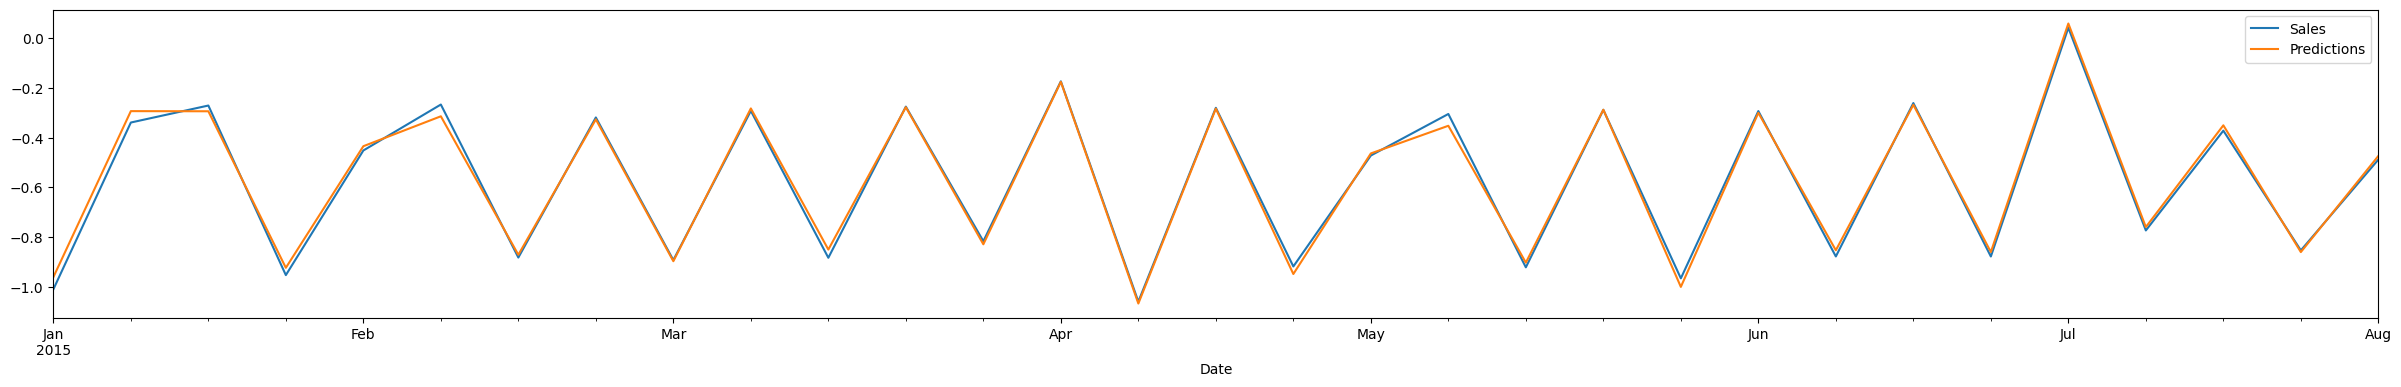

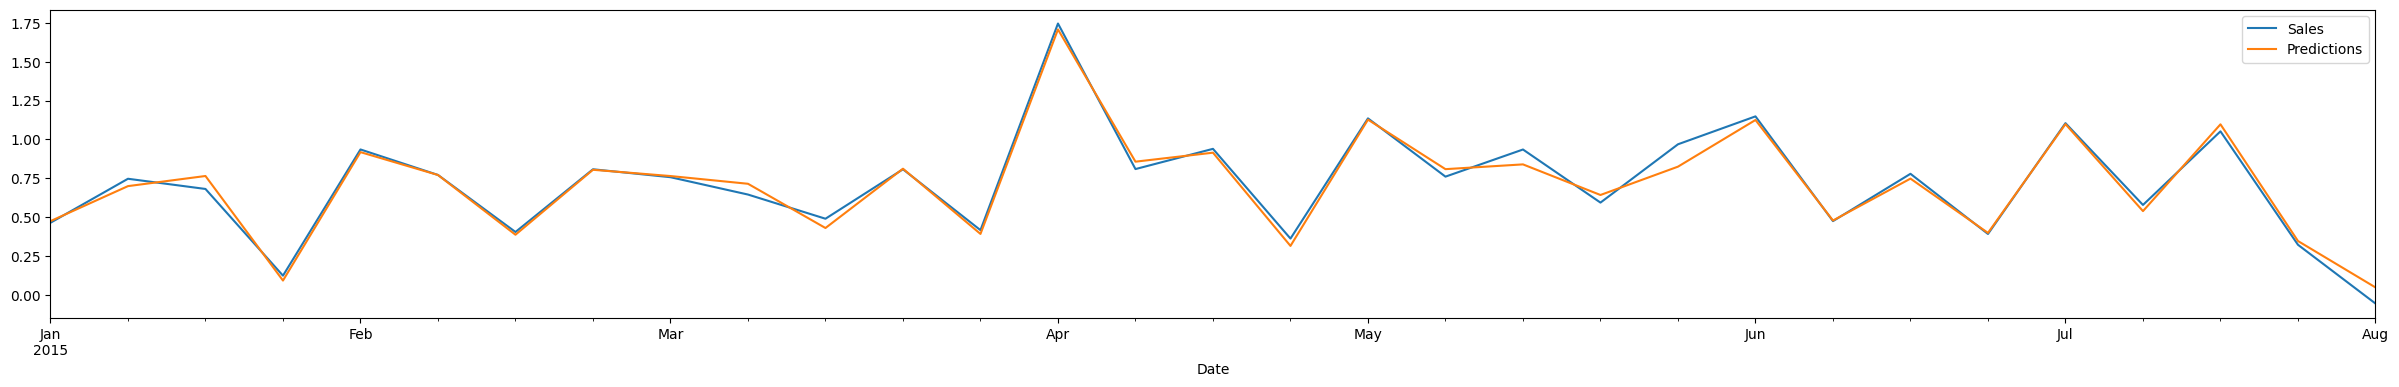

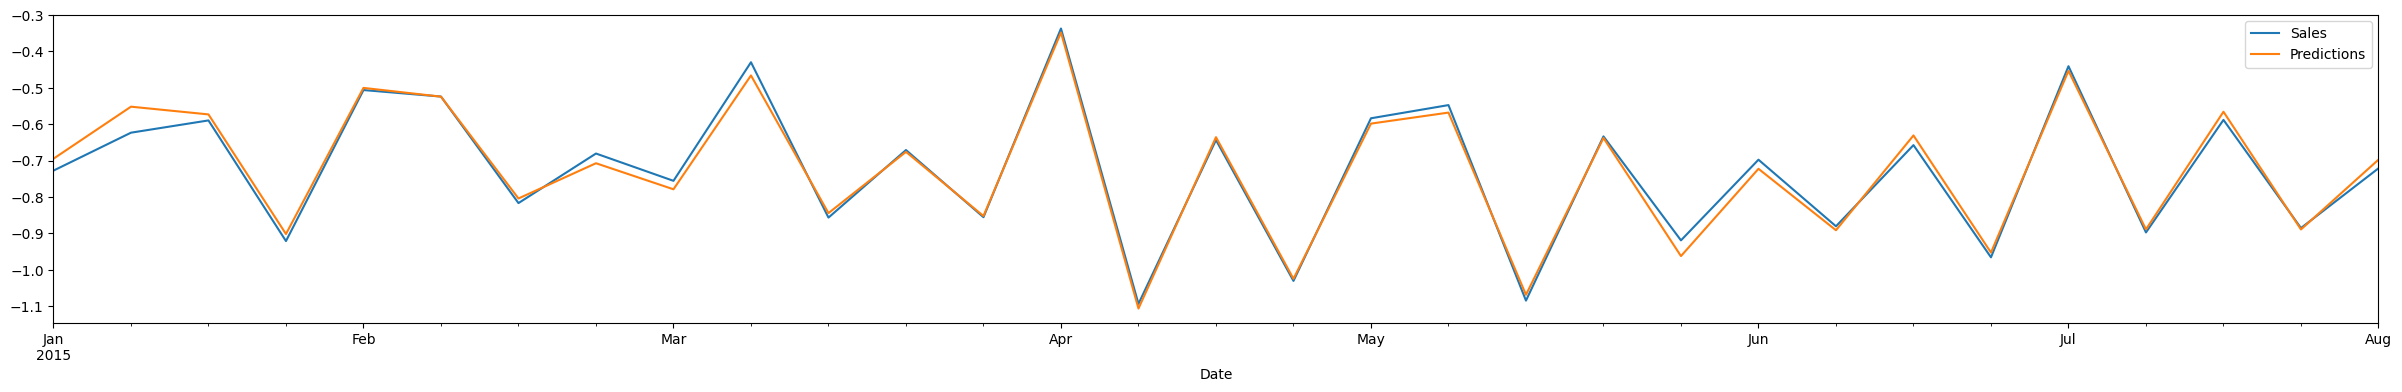

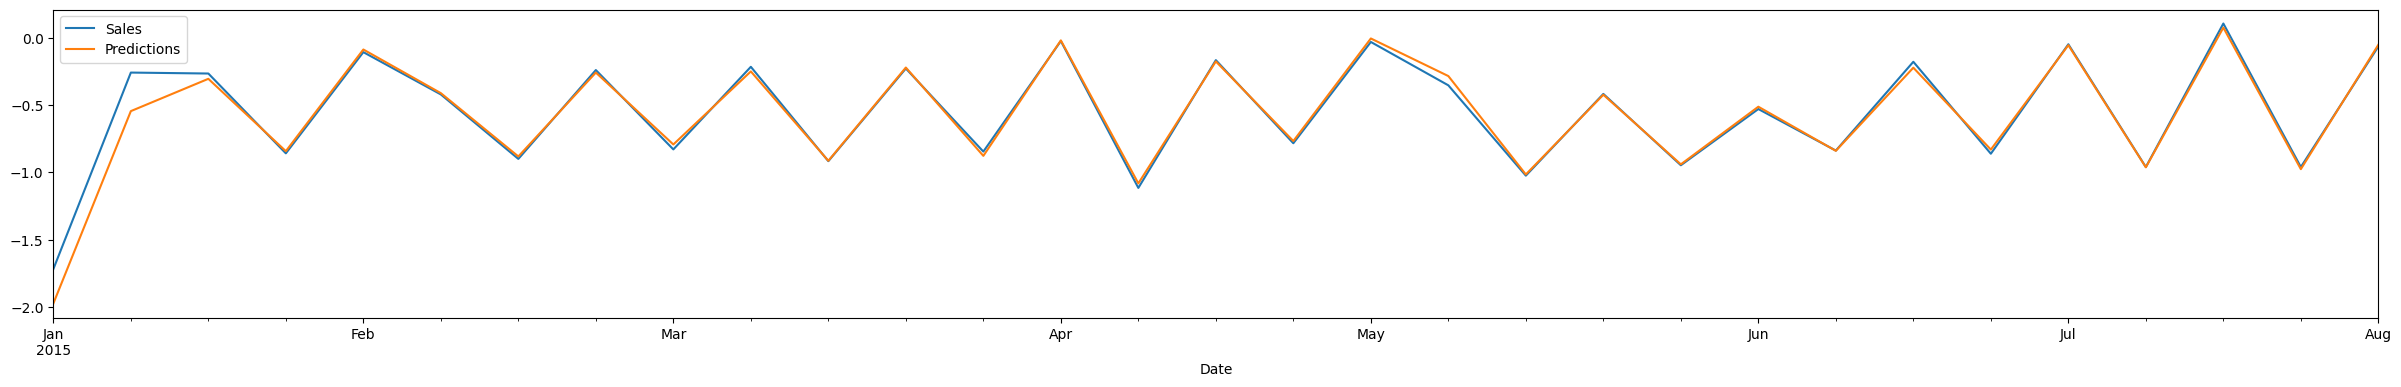

In [17]:
selected_stores = {
    "a": 2,
    "b": 85,
    "c": 1,
    "d": 13
}

for store_type, store_id in selected_stores.items():
    sample = validation_weekly_stores_sales_df[validation_weekly_stores_sales_df.Store == store_id].set_index("Date")
    sample["Predictions"] = xgbr_regressor.predict(sample.drop("Sales", axis="columns"))

    plt.figure()
    
    ax = sample["Sales"].plot(kind="line", figsize=(30, 4))
    sample["Predictions"].plot(kind="line", ax=ax)
    ax.legend();

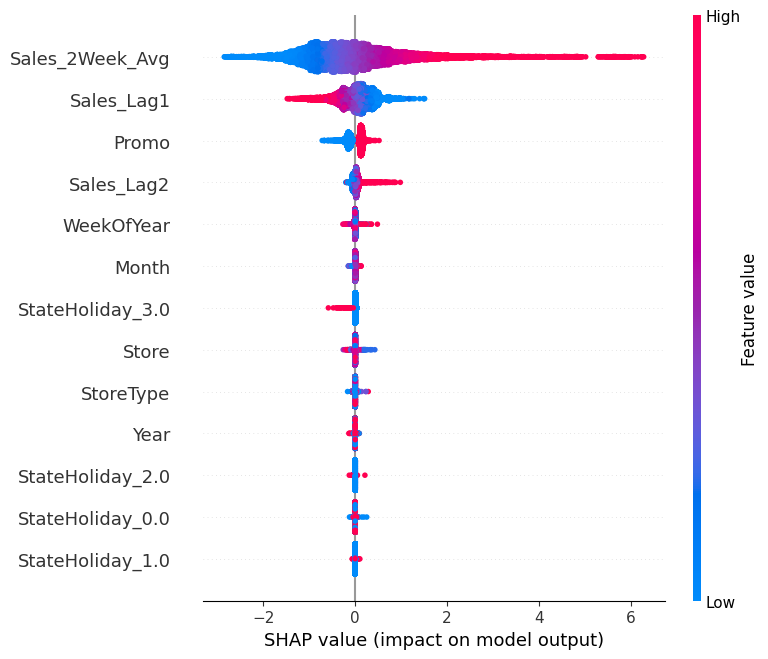

In [18]:
explainer = shap.Explainer(xgbr_regressor)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)